# **Wildfire Risk Prediction**
### **Data Mining**
**Student:** Yusuf Turan
**Date:** December 2025
**System:** Linux (Ubuntu) - Apache Spark Local Cluster

## **1. Project Objective**
Forest fires are critical natural disasters affecting the Mediterranean ecosystem. This project aims to build a **Big Data Machine Learning Pipeline** to predict wildfire risks in Turkey. We utilize **multi-source data fusion** (NASA FIRMS, ERA5 Climate, SRTM Topography, MODIS Vegetation) and compare four different classification algorithms.

## **2. Methodology**
1.  **Data Ingestion:** Loading raw satellite fire detections.
2.  **Synthetic Sampling:** Generating pseudo-absence (non-fire) points to balance the dataset.
3.  **EDA (Part 1):** Analyzing raw spatial and temporal patterns.
4.  **Data Enrichment (ETL):** Using **Google Earth Engine (GEE)** API to extract environmental features for 400,000+ points.
5.  **EDA (Part 2):** Analyzing correlations, distributions, and missing values.
6.  **Modeling:** Training **Random Forest, GBT, Logistic Regression, and SVM** models using Spark MLlib.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lpad, substring, lit, when, month, year, hour, count, isnan
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, DateType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import os
import random
import glob
from datetime import date, timedelta

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

# This settings for the computer which these codes have runned.
spark = SparkSession.builder \
    .appName("ALAZ_Final_Project_Linux") \
    .master("local[3]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.mergeSchema", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

/home/turan/anaconda3/envs/alaz_env/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
25/12/17 00:47:19 WARN Utils: Your hostname, turan-H110 resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface enp2s0)
25/12/17 00:47:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/17 00:47:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.1


### STEP 1: RAW DATA INGESTION

In [2]:
RAW_CSV_PATH = "../data/raw/modis_turkey.csv" 
SKELETON_PATH = "../data/processed/training_dataset_skeleton.parquet"

print("Reading Raw CSV Data...")
df_raw = spark.read.csv(RAW_CSV_PATH, header=True, inferSchema=True)

# Filter High Confidence Fires
df_fire = df_raw.filter(col("confidence") >= 50) \
    .withColumn("acq_time_str", lpad(col("acq_time").cast("string"), 4, "0")) \
    .select(
        col("latitude"), col("longitude"),
        to_date(col("acq_date"), "yyyy-MM-dd").alias("date"),
        substring(col("acq_time_str"), 1, 2).cast("int").alias("hour"),
        lit(1).alias("label") 
    )

fire_count = df_fire.count()
print(f"Positive Samples (Fire): {fire_count}")

# Generate Negative Samples (Pseudo-Absence)
print("Generating Synthetic Non-Fire Samples...")
def generate_random_data(num_samples):
    data = []
    start_date = date(2000, 1, 1)
    end_date = date(2023, 12, 31)
    days_range = (end_date - start_date).days
    for _ in range(num_samples):
        lat = random.uniform(36.0, 42.0)
        lon = random.uniform(26.0, 45.0)
        random_date = start_date + timedelta(days=random.randint(0, days_range))
        random_hour = random.randint(0, 23)
        data.append((lat, lon, random_date, random_hour, 0))
    return data

# Generate slightly more negatives to be safe
random_data = generate_random_data(fire_count + 5000)
schema = StructType([
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("date", DateType(), True),
    StructField("hour", IntegerType(), True),
    StructField("label", IntegerType(), True)
])

df_non_fire = spark.createDataFrame(random_data, schema)
df_skeleton = df_fire.union(df_non_fire)

df_skeleton.write.mode("overwrite").parquet(SKELETON_PATH)
print(f"Dataset Saved: {df_skeleton.count()} rows.")

Reading Raw CSV Data...


Positive Samples (Fire): 202014
Generating Synthetic Non-Fire Samples...


25/12/17 00:50:33 WARN TaskSetManager: Stage 5 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.
25/12/17 00:50:35 WARN TaskSetManager: Stage 6 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.
[Stage 6:=======================================>                   (4 + 2) / 6]

Dataset Saved: 409028 rows.


## **3. Exploratory Data Analysis (EDA) - Phase 1: Raw Data**
Before enriching the data, we analyze the spatiotemporal distribution of the raw fire events to check for consistency and missing values in the skeleton dataset.

25/12/17 00:54:46 WARN TaskSetManager: Stage 10 contains a task of very large size (1885 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

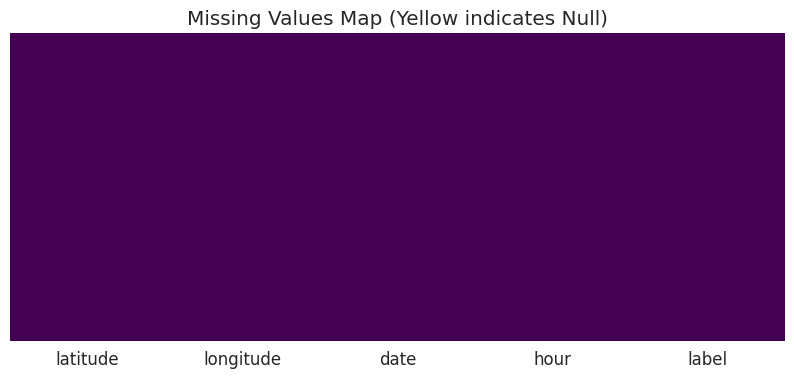

Null Values Count per Column:
latitude     0
longitude    0
date         0
hour         0
label        0
dtype: int64


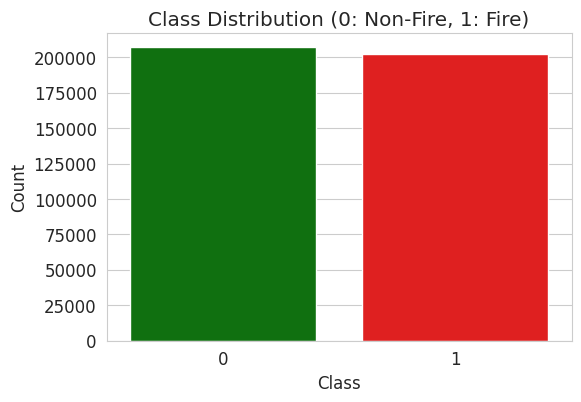

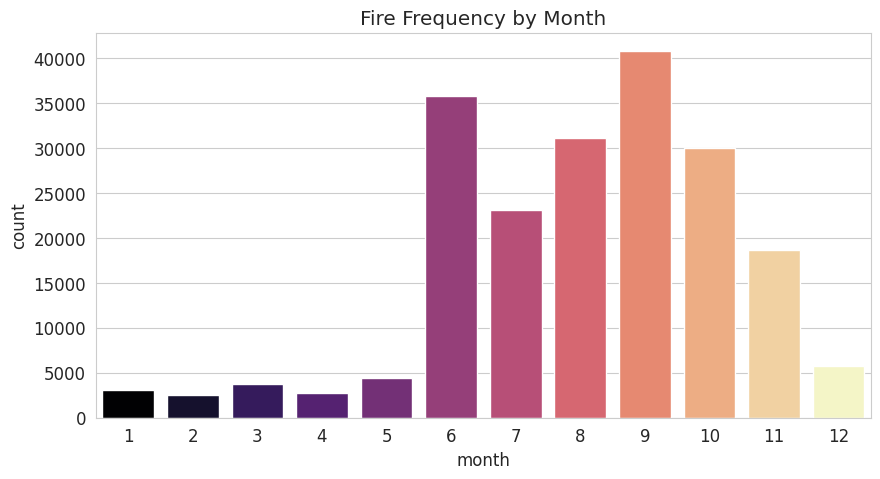

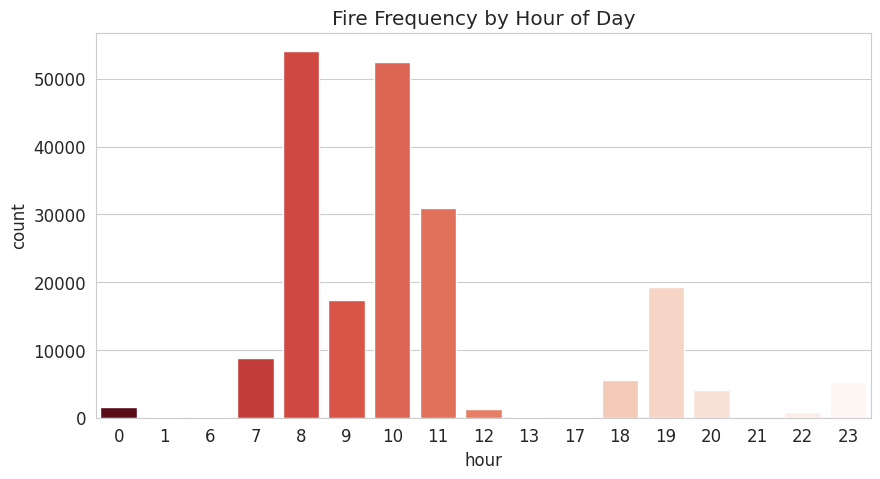

In [4]:
# Convert to Pandas for Visualization
pdf_skeleton = df_skeleton.toPandas()

# 1. Null Value Check
plt.figure(figsize=(10, 4))
sns.heatmap(pdf_skeleton.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Map (Yellow indicates Null)")
plt.show()

# Check Null Counts Programmatically
print("Null Values Count per Column:")
print(pdf_skeleton.isnull().sum())

# 2. Class Balance Check
plt.figure(figsize=(6, 4))
sns.countplot(x='label', hue='label', data=pdf_skeleton, palette={0: 'green', 1: 'red', '0': 'green', '1': 'red'}, legend=False)
plt.title("Class Distribution (0: Non-Fire, 1: Fire)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 3. Fire Frequency by Month (Seasonality)
pdf_skeleton['month'] = pd.to_datetime(pdf_skeleton['date']).dt.month
fire_data = pdf_skeleton[pdf_skeleton['label'] == 1]

plt.figure(figsize=(10, 5))
sns.countplot(x='month', hue='month', data=fire_data, palette='magma', legend=False)
plt.title("Fire Frequency by Month")
plt.show()

# 4. Fire Frequency by Hour
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', hue='hour', data=fire_data, palette='Reds_r', legend=False)
plt.title("Fire Frequency by Hour of Day")
plt.show()

### STEP 2: DATA ENRICHMENT (Google Earth Engine)

In [11]:
import ee
import pandas as pd

try:
    ee.Initialize()
    print("GEE Initialized.")
except:
    ee.Authenticate()
    ee.Initialize()

def extract_features(df_chunk):
    features = []
    for index, row in df_chunk.iterrows():
        dt_str = f"{row['date']} {row['hour']}:00:00"
        millis = pd.Timestamp(dt_str).value // 10**6
        g = ee.Geometry.Point([row['longitude'], row['latitude']])
        f = ee.Feature(g, {'system:time_start': millis, 'orig_id': index})
        features.append(f)
    
    fc = ee.FeatureCollection(features)

    def process_point(feature):
        date = ee.Date(feature.get('system:time_start'))
        
        # 1. Topography (SRTM)
        srtm = ee.Image("USGS/SRTMGL1_003").unmask(-999)
        terrain = ee.Algorithms.Terrain(srtm)
        
        # 2. Meteorology (ERA5)
        era5_col = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(date, date.advance(1, 'hour'))
        
        era5_bands = ['temperature_2m','u_component_of_wind_10m','v_component_of_wind_10m','dewpoint_temperature_2m','total_precipitation_hourly','soil_temperature_level_1']
        
        fallback_era5 = ee.Image.constant([-999]*6).rename(era5_bands)
        
        era5_img = ee.Image(ee.Algorithms.If(
            era5_col.size().gt(0), 
            era5_col.first().unmask(-999), 
            fallback_era5
        ))
        
        modis_col = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(date.advance(-20, 'day'), date).sort('system:time_start', False)
        fallback_modis = ee.Image.constant([-999]).rename(['NDVI'])
        
        modis_img = ee.Image(ee.Algorithms.If(
            modis_col.size().gt(0), 
            modis_col.first().unmask(-999), 
            fallback_modis
        ))
        
        # Combine
        combined = srtm.addBands(terrain).addBands(era5_img).addBands(modis_img)
        
        # Reduce Region
        data = combined.reduceRegion(reducer=ee.Reducer.first(), geometry=feature.geometry(), scale=1000, tileScale=4)
        
        def safe_calc(val_name, subtract_val=0):
            val = ee.Number(data.get(val_name))
            return ee.Algorithms.If(val.lt(-900), -999, val.subtract(subtract_val))

        temp_c = safe_calc('temperature_2m', 273.15)
        
        # NDVI
        ndvi_raw = ee.Number(data.get('NDVI'))
        ndvi = ee.Algorithms.If(ndvi_raw.lt(-900), -999, ndvi_raw.multiply(0.0001))
        
        u = ee.Number(data.get('u_component_of_wind_10m'))
        v = ee.Number(data.get('v_component_of_wind_10m'))
        wind = ee.Algorithms.If(u.lt(-900).Or(v.lt(-900)), -999, (u.pow(2).add(v.pow(2))).sqrt())
        
        t_raw = ee.Number(data.get('temperature_2m'))
        dew = ee.Number(data.get('dewpoint_temperature_2m'))
        
        rh = ee.Algorithms.If(
            t_raw.lt(-900).Or(dew.lt(-900)), -999,
            ee.Number(100).multiply(
                ((ee.Number(17.625).multiply(dew.subtract(273.15))).divide(ee.Number(243.04).add(dew.subtract(273.15)))).exp() \
                .divide(((ee.Number(17.625).multiply(t_raw.subtract(273.15))).divide(ee.Number(243.04).add(t_raw.subtract(273.15)))).exp())
            )
        )

        precip = data.get('total_precipitation_hourly')
        soil_c = safe_calc('soil_temperature_level_1', 273.15)

        return feature.set({
            'elevation': data.get('elevation'), 
            'slope': data.get('slope'), 
            'aspect': data.get('aspect'),
            'temperature': temp_c, 
            'wind_speed': wind, 
            'humidity': rh,
            'precipitation': precip, 
            'soil_temperature': soil_c, 
            'NDVI': ndvi
        })

    try:
        info = fc.map(process_point, True).getInfo()
        data_list = []
        for f in info['features']:
            p = f['properties']
            p['orig_id'] = int(f['properties']['orig_id'])
            data_list.append(p)
        return pd.DataFrame(data_list)
        
    except Exception as e:
        print(f"\nGEE Error (Batch Skipped): {e}")
        return pd.DataFrame()

GEE Initialized.


In [12]:
import os

OUTPUT_DIR = "../data/processed/chunks"
if not os.path.exists(OUTPUT_DIR): 
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

df_pandas = spark.read.parquet(SKELETON_PATH).toPandas()
df_pandas = df_pandas.reset_index(drop=True)

batch_size = 2000
total_len = len(df_pandas)

print(f"Starting Processing for {total_len} rows...")

for i in range(0, total_len, batch_size):
    fname = f"{OUTPUT_DIR}/chunk_{i}.parquet"
    
    if os.path.exists(fname): 
        if i % 10000 == 0: print(f"Skipping {i} (Already exists)")
        continue
    
    print(f"Processing batch {i} / {total_len}...", end="\r")
    
    chunk = df_pandas.iloc[i : i + batch_size].copy()
    
    chunk_res = extract_features(chunk)
    
    if not chunk_res.empty:
        chunk_res.set_index('orig_id', inplace=True)
        
        df_merged = chunk.join(chunk_res, how='left')
        
        for col_name in df_merged.columns:
             if df_merged[col_name].dtype == object:
                 df_merged[col_name] = df_merged[col_name].astype(str)
        
        df_merged.to_parquet(fname)
    else:
        print(f"\nChunk {i} returned EMPTY! (GEE Error occurred)")

print("\nAll chunks processed successfully!")

Starting Processing for 409028 rows...
Processing batch 408000 / 409028...
All chunks processed successfully!


### STEP 3: MERGE & CLEAN

In [13]:
print("Merging chunks...")
df_raw = spark.read.option("mergeSchema", "true").parquet(f"{OUTPUT_DIR}/*.parquet")

cols = ['elevation', 'slope', 'aspect', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'soil_temperature', 'NDVI']
for c in cols:
    if c in df_raw.columns: 
        df_raw = df_raw.withColumn(c, col(c).cast(DoubleType()))

# Data Cleaning
df_clean = df_raw.filter((col("temperature") > -100) & (col("NDVI") > -1)).na.drop()

FINAL_PATH = "../data/processed/ALAZ_Final_Project_Data.parquet"
df_clean.coalesce(1).write.mode("overwrite").parquet(FINAL_PATH)

print(f"Final Dataset Created: {df_clean.count()} rows.")

Merging chunks...


[Stage 22:=========================================>                (5 + 2) / 7]

Final Dataset Created: 371239 rows.


## **4. EDA Phase 2: Enriched Dataset Analysis**
Now that we have meteorological and topographical data, we can analyze the relationships between environmental factors and fire occurrences.

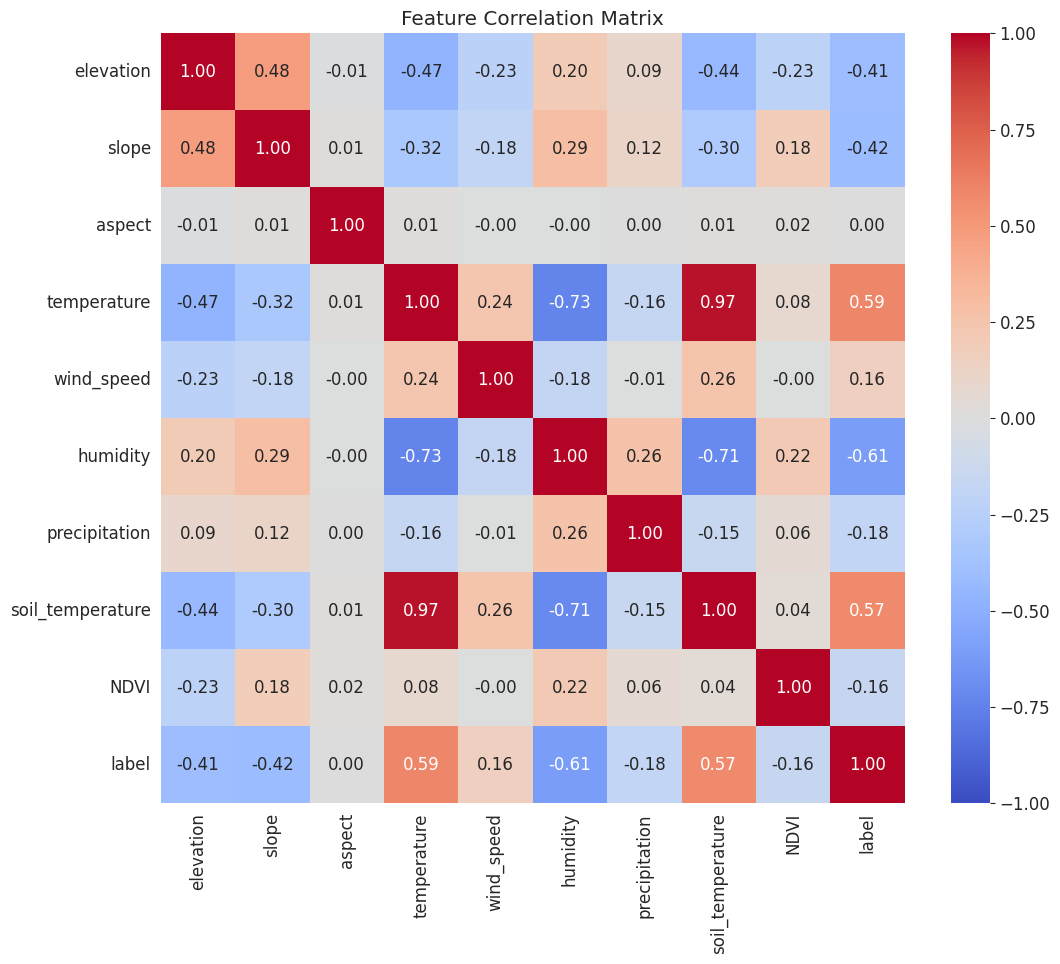

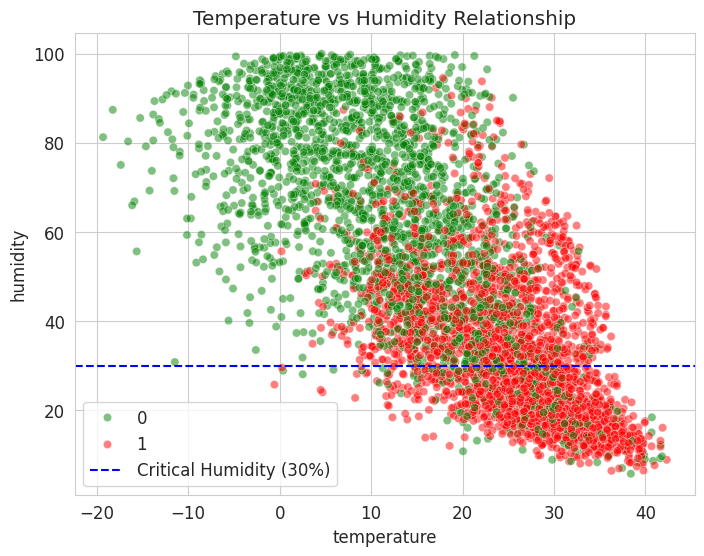

/tmp/ipykernel_5244/853522705.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='elevation', data=pdf, palette="Set2", split=True)


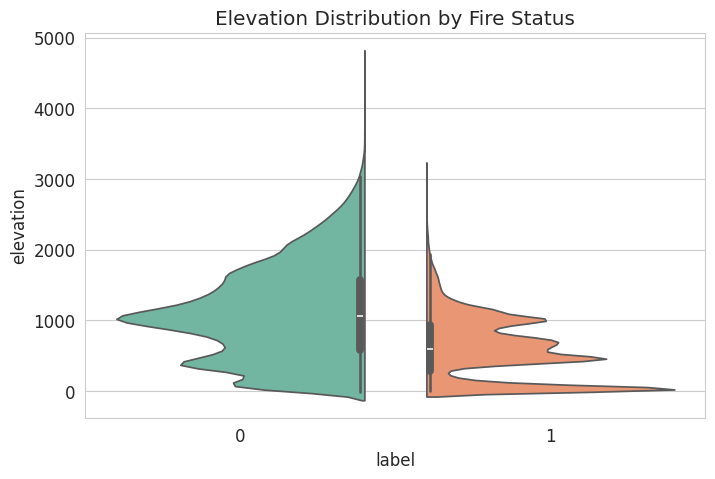

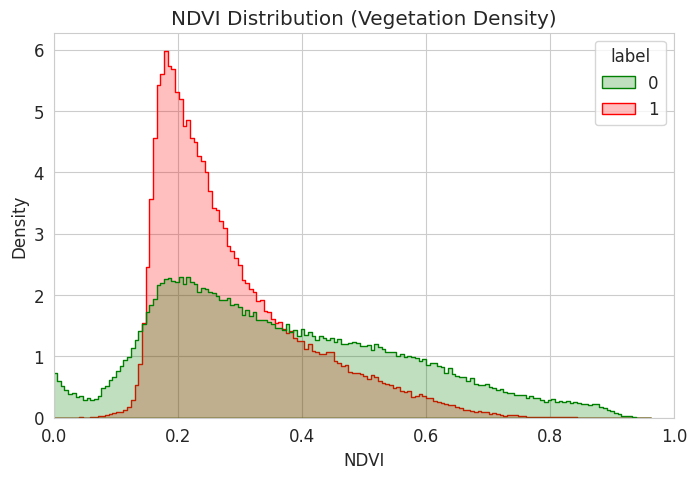

/tmp/ipykernel_5244/853522705.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=pdf[pdf['label']==0]['wind_speed'], shade=True, color="green", label="Non-Fire")
/tmp/ipykernel_5244/853522705.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=pdf[pdf['label']==1]['wind_speed'], shade=True, color="red", label="Fire")


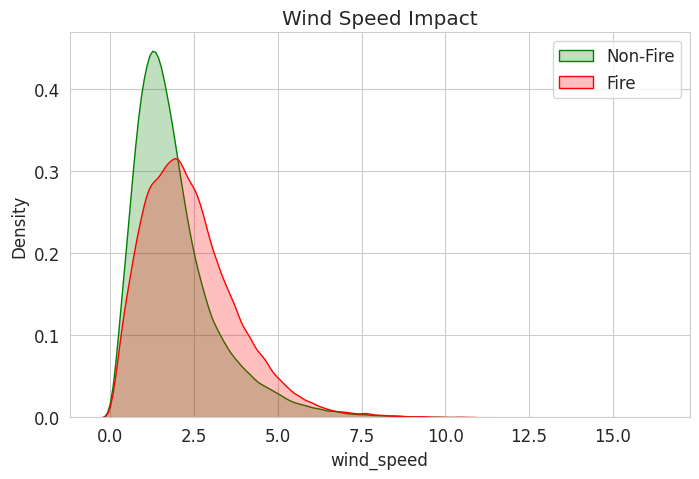

In [14]:
# Convert Final Data to Pandas
pdf = df_clean.toPandas()

# 5. Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
corr_cols = ['elevation', 'slope', 'aspect', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'soil_temperature', 'NDVI', 'label']
corr = pdf[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

# 6. Temperature vs Humidity Scatter (The Fire Triangle)
plt.figure(figsize=(8, 6))
sample = pdf.sample(n=5000, random_state=42)
sns.scatterplot(data=sample, x='temperature', y='humidity', hue='label', palette={0:'green', 1:'red'}, alpha=0.5)
plt.axhline(y=30, color='blue', linestyle='--', label="Critical Humidity (30%)")
plt.title("Temperature vs Humidity Relationship")
plt.legend()
plt.show()

# 7. Elevation Distribution
plt.figure(figsize=(8, 5))
sns.violinplot(x='label', y='elevation', data=pdf, palette="Set2", split=True)
plt.title("Elevation Distribution by Fire Status")
plt.show()

# 8. NDVI Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=pdf, x="NDVI", hue="label", element="step", stat="density", common_norm=False, palette={0:'green', 1:'red'})
plt.title("NDVI Distribution (Vegetation Density)")
plt.xlim(0, 1)
plt.show()

# 9. Wind Speed Density
plt.figure(figsize=(8, 5))
sns.kdeplot(data=pdf[pdf['label']==0]['wind_speed'], shade=True, color="green", label="Non-Fire")
sns.kdeplot(data=pdf[pdf['label']==1]['wind_speed'], shade=True, color="red", label="Fire")
plt.title("Wind Speed Impact")
plt.legend()
plt.show()

### STEP 4: MODELING

Training Models...
   -> Training Random Forest...


25/12/17 10:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1821.3 KiB
25/12/17 10:36:18 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/12/17 10:36:26 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/12/17 10:36:35 WARN DAGScheduler: Broadcasting large task binary with size 1665.6 KiB
25/12/17 10:36:37 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/12/17 10:36:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

   -> Training GBT...


25/12/17 10:37:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

   -> Training Logistic Regression...


   -> Training Linear SVM...


[Stage 343:======================================>                  (2 + 1) / 3]


LEADERBOARD


,Accuracy,F1 Score
Random Forest,0.878025,0.877154
GBT,0.872554,0.871860
Linear SVM,0.854404,0.853259
Logistic Regression,0.852625,0.851839


<Figure size 800x500 with 0 Axes>

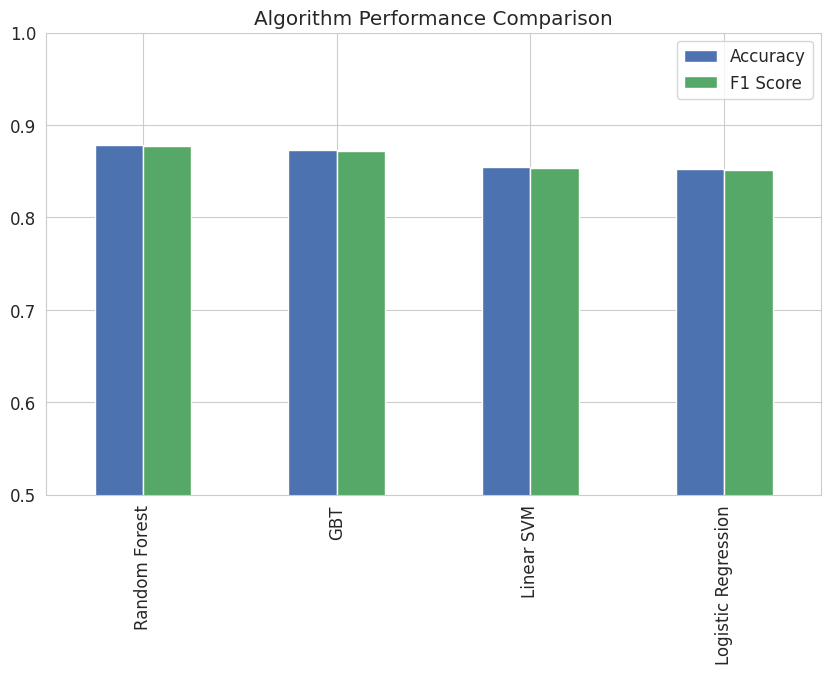

Please let's protect nature.


In [15]:
df = spark.read.parquet(FINAL_PATH)

assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_ml = assembler.transform(df).select("features", "label")
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

models = {
    "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxDepth=10),
    "GBT": GBTClassifier(labelCol="label", featuresCol="features", maxIter=20),
    "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="features", maxIter=20),
    "Linear SVM": LinearSVC(labelCol="label", featuresCol="features", maxIter=20)
}

results = {}
print("Training Models...")

for name, algo in models.items():
    print(f"   -> Training {name}...")
    model = algo.fit(train)
    preds = model.transform(test)
    
    acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(preds)
    f1 = MulticlassClassificationEvaluator(metricName="f1").evaluate(preds)
    results[name] = {"Accuracy": acc, "F1 Score": f1}

# 10. Model Comparison Chart
res_df = pd.DataFrame(results).transpose().sort_values(by="F1 Score", ascending=False)
print("\nLEADERBOARD")
display(res_df)

plt.figure(figsize=(8, 5))
res_df[["Accuracy", "F1 Score"]].plot(kind="bar", color=['#4c72b0', '#55a868'])
plt.title("Algorithm Performance Comparison")
plt.ylim(0.5, 1.0)
plt.show()

print("Please let's protect nature.")